# Projekt IAU  
## 1. časť - Prieskumná analýza 
### Vypracovali: Martin Kukučka, Martin Jankuliak

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import glob

import datetime
from datetime import datetime,date
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import json
import re
import dateutil.parser as parser
import statsmodels.api as sm

import scipy as sc
from pandas import read_csv


### Načítanie dát

In [74]:
df_other_train = read_csv("data/other_train.csv")
df_personal_train = read_csv("data/personal_train.csv")

## Základný opis dát spolu s ich charakteristikami 

### Dataset other_train.csv

Pre predstavu tu je ukážka datasetu

In [3]:
df_other_train.head()

,Unnamed: 0,name,address,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,education,fnlwgt,class,income,medical_info,native-country,hours-per-week,capital-loss,workclass
0,0,Robert Plante,"3594 Johnson Green Suite 277\r\nJohnsonport, V...",White,Widowed,Other-service,f,5.0,Unmarried,0.0,9th,220019.0,1.0,<=50K,"{'mean_glucose':'106.71875','std_glucose':'48....",United-States,9.0,0.0,Private
1,1,Richard Huey,"350 Lewis Haven\r\nAngelaton, IN 39486",Asian-Pac-Islander,Never-married,Handlers-cleaners,f,13.0,Not-in-family,0.0,Bachelors,196899.0,0.0,<=50K,"{'mean_glucose':'118.609375','std_glucose':'na...",Haiti,50.0,0.0,Private
2,2,Joseph Sable,22509 Adrian Canyon Suite 799\r\nEast Timothyt...,White,Never-married,Exec-managerial,f,9.0,Unmarried,0.0,HS-grad,301591.0,0.0,<=50K,"{'mean_glucose':'129.4609375','std_glucose':'5...",United-States,35.0,0.0,Private
3,3,Gregory Preston,"2674 Daryl Island\r\nLake Sean, TN 89363",White,Married-civ-spouse,Exec-managerial,f,13.0,Husband,0.0,Bachelors,310320.0,1.0,>50K,"{'mean_glucose':'30.1015625','std_glucose':'37...",United-States,40.0,0.0,Private
4,4,Mike Riley,023 Joseph Estate Suite 799\r\nLake Andrewvill...,White,Married-civ-spouse,Handlers-cleaners,f,9.0,Husband,0.0,HS-grad,237943.0,0.0,<=50K,"{'mean_glucose':'124.0390625','std_glucose':'4...",United-States,60.0,0.0,private


Pomocou tohto príkazu zistíme počet riadkov

In [4]:
df_other_train.shape[0]

3983

A teraz počet atribútov pre tento dataset

In [5]:
df_other_train.shape[1]

19

Typy atribútov zistíme týmto príkazom

In [6]:
df_other_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3983 non-null   int64  
 1   name            3983 non-null   object 
 2   address         3983 non-null   object 
 3   race            3691 non-null   object 
 4   marital-status  3970 non-null   object 
 5   occupation      3961 non-null   object 
 6   pregnant        3969 non-null   object 
 7   education-num   3961 non-null   float64
 8   relationship    3954 non-null   object 
 9   capital-gain    3969 non-null   float64
 10  education       3972 non-null   object 
 11  fnlwgt          3968 non-null   float64
 12  class           3960 non-null   float64
 13  income          3972 non-null   object 
 14  medical_info    3966 non-null   object 
 15  native-country  3966 non-null   object 
 16  hours-per-week  3966 non-null   float64
 17  capital-loss    3973 non-null   f

Zistile sme, že tento dataset je zložený z atribútov:
- 6x float
- 1x int
- 12x object

Ďalej tu vidíme aj počet riadkov: 3983 ("RangeIndex: 3983 entries"),
a počet stĺpcov: 19 ("Data columns (total 19 columns)")

Nakoniec sa pozrieme na desktiptívne štatistiky.

In [7]:
df_other_train.describe()

,Unnamed: 0,education-num,capital-gain,fnlwgt,class,hours-per-week,capital-loss
count,3983.00000,3961.000000,3969.000000,3968.000000,3960.000000,3966.000000,3973.000000
mean,1991.00000,10.052764,1134.530108,189963.996976,0.256313,40.203984,72.926252
std,1149.93739,2.520019,8067.028170,102327.438172,0.436652,12.317838,360.910859
min,0.00000,1.000000,0.000000,20308.000000,0.000000,1.000000,0.000000
25%,995.50000,9.000000,0.000000,119475.250000,0.000000,40.000000,0.000000
50%,1991.00000,10.000000,0.000000,180585.500000,0.000000,40.000000,0.000000
75%,2986.50000,12.000000,0.000000,236173.000000,1.000000,45.000000,0.000000
max,3982.00000,16.000000,99999.000000,795830.000000,1.000000,99.000000,2824.000000


V tejto tabuľke vidíme ako sú: počet záznamov, priemer, štandardnú odchýlku, minimum, prvý kvartil, druhý kvartil (medián), tretí kvartil, maximum, pre všetky atribúty, ktoré obsahujú numerické hodnoty.

### Dataset personal_train.csv

Rovnako vykonáme opis dát aj pre druhý dataset

Ukážka datasetu

In [8]:
df_personal_train.head()

,Unnamed: 0,name,address,age,sex,date_of_birth
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",58,Male,1961-04-27
1,1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",43,Female,1976-09-12
2,2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",51,Male,1967-11-12
3,3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",66,Male,1953-06-02
4,4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",45,Female,1974/09/11


Počet riadkov

In [9]:
df_personal_train.shape[0]

3933

Počet atribútov

In [10]:
df_personal_train.shape[1]

6

Typy atribútov

In [11]:
df_personal_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     3933 non-null   int64 
 1   name           3933 non-null   object
 2   address        3933 non-null   object
 3   age            3933 non-null   int64 
 4   sex            3933 non-null   object
 5   date_of_birth  3933 non-null   object
dtypes: int64(2), object(4)
memory usage: 184.5+ KB


Zistile sme, že tento dataset je zložený z atribútov:
- 2x int
- 4x object

Ďalej tu vidíme aj počet riadkov: 3933 ("RangeIndex: 3933 entries"),
a počet stĺpcov: 6 ("Data columns (total 6 columns)")

A Nakoniec desktiptívne štatistiky.

In [12]:
df_personal_train.describe()

,Unnamed: 0,age
count,3933.000000,3933.000000
mean,1966.000000,51.816934
std,1135.503633,11.814803
min,0.000000,-1.000000
25%,983.000000,44.000000
50%,1966.000000,52.000000
75%,2949.000000,60.000000
max,3932.000000,113.000000


## Párová analýza dát

In [97]:
df_other_train_analysis = read_csv("data/other_train.csv")
df_personal_train_analysis = read_csv("data/personal_train.csv")

df_other_train_analysis.columns = df_other_train_analysis.columns.str.replace('-','_')
df_personal_train_analysis.columns = df_personal_train_analysis.columns.str.replace('-','_')

df_other_train_analysis.head()

,Unnamed: 0,name,address,race,marital_status,occupation,pregnant,education_num,relationship,capital_gain,education,fnlwgt,class,income,medical_info,native_country,hours_per_week,capital_loss,workclass
0,0,Robert Plante,"3594 Johnson Green Suite 277\r\nJohnsonport, V...",White,Widowed,Other-service,f,5.0,Unmarried,0.0,9th,220019.0,1.0,<=50K,"{'mean_glucose':'106.71875','std_glucose':'48....",United-States,9.0,0.0,Private
1,1,Richard Huey,"350 Lewis Haven\r\nAngelaton, IN 39486",Asian-Pac-Islander,Never-married,Handlers-cleaners,f,13.0,Not-in-family,0.0,Bachelors,196899.0,0.0,<=50K,"{'mean_glucose':'118.609375','std_glucose':'na...",Haiti,50.0,0.0,Private
2,2,Joseph Sable,22509 Adrian Canyon Suite 799\r\nEast Timothyt...,White,Never-married,Exec-managerial,f,9.0,Unmarried,0.0,HS-grad,301591.0,0.0,<=50K,"{'mean_glucose':'129.4609375','std_glucose':'5...",United-States,35.0,0.0,Private
3,3,Gregory Preston,"2674 Daryl Island\r\nLake Sean, TN 89363",White,Married-civ-spouse,Exec-managerial,f,13.0,Husband,0.0,Bachelors,310320.0,1.0,>50K,"{'mean_glucose':'30.1015625','std_glucose':'37...",United-States,40.0,0.0,Private
4,4,Mike Riley,023 Joseph Estate Suite 799\r\nLake Andrewvill...,White,Married-civ-spouse,Handlers-cleaners,f,9.0,Husband,0.0,HS-grad,237943.0,0.0,<=50K,"{'mean_glucose':'124.0390625','std_glucose':'4...",United-States,60.0,0.0,private


In [100]:
data_frame = {}
med_inf = df_other_train_analysis.medical_info
med_inf = med_inf.str.replace("'", '"').tolist()
data_keys = json.loads(med_inf[0]).keys()

for data_key in data_keys:
    data_frame[data_key] = []

for data in med_inf:
    if isinstance(data, str):
        values = json.loads(data)
        for data_key in data_keys:
            data_frame[data_key].append(values[data_key])
    else:
        for data_key in data_keys:
            data_frame[data_key].append(np.NaN)

In [101]:
data_frame = pd.DataFrame(data_frame)
data_frame.head()

,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,106.71875,48.59991922,0.48313819,0.060911664,6.269230769,29.92992523,6.026227617999999,38.46886389
1,118.609375,nan,0.386486255,-0.391453476,6.880434782999999,31.45280882,4.726094845,22.1326697
2,129.4609375,51.84771908,0.097801521,-0.17631789,1.074414716,12.3100408,14.03786226,224.8662321
3,30.1015625,37.99585501,4.505472298,20.78517939,75.45234114,78.74218273,0.894009245,-0.437248907
4,124.0390625,46.68133365,0.113198941,0.403242952,5.68812709,26.33443057,5.662103534,35.99633243


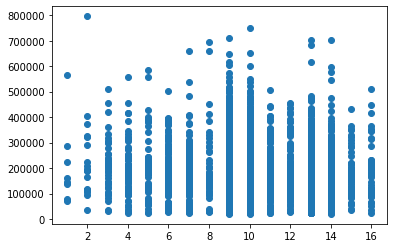

In [78]:
plt.scatter(df_other_train_analysis.education_num, df_other_train.fnlwgt)

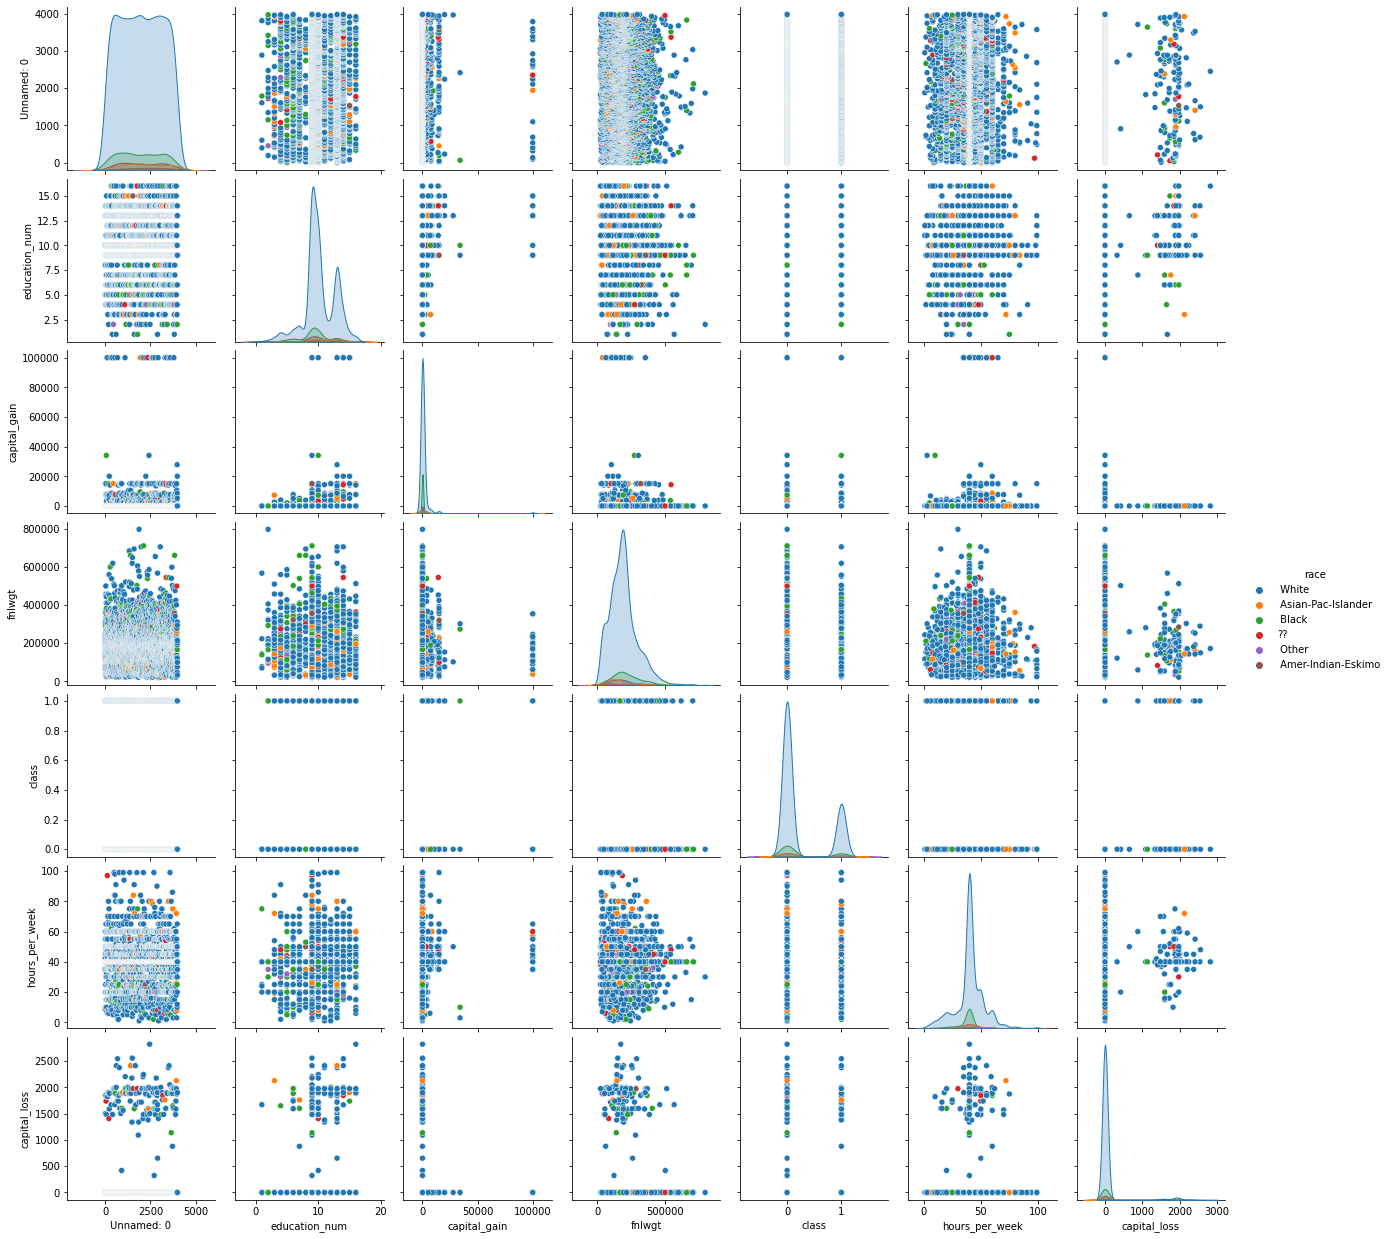

In [80]:
sns.pairplot(df_other_train_analysis, hue="race")

Pearson correlation: -0.021


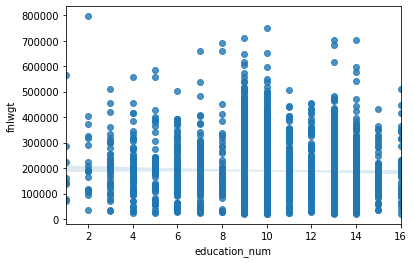

In [81]:
sns.regplot(x="education_num", y="fnlwgt", data=df_other_train_analysis)
print("Pearson correlation: %.3f" % df_other_train_analysis.education_num.corr(df_other_train_analysis.fnlwgt))

In [82]:
df_other_train_analysis.corr()

,Unnamed: 0,education_num,capital_gain,fnlwgt,class,hours_per_week,capital_loss
Unnamed: 0,1.000000,0.026433,0.014192,0.009520,-0.019542,0.002343,0.010869
education_num,0.026433,1.000000,0.123889,-0.021473,-0.016022,0.145341,0.073644
capital_gain,0.014192,0.123889,1.000000,-0.004133,-0.004884,0.062525,-0.028330
fnlwgt,0.009520,-0.021473,-0.004133,1.000000,-0.008495,-0.019431,0.001739
class,-0.019542,-0.016022,-0.004884,-0.008495,1.000000,-0.018250,0.014470
hours_per_week,0.002343,0.145341,0.062525,-0.019431,-0.018250,1.000000,0.062131
capital_loss,0.010869,0.073644,-0.028330,0.001739,0.014470,0.062131,1.000000


<AxesSubplot:>

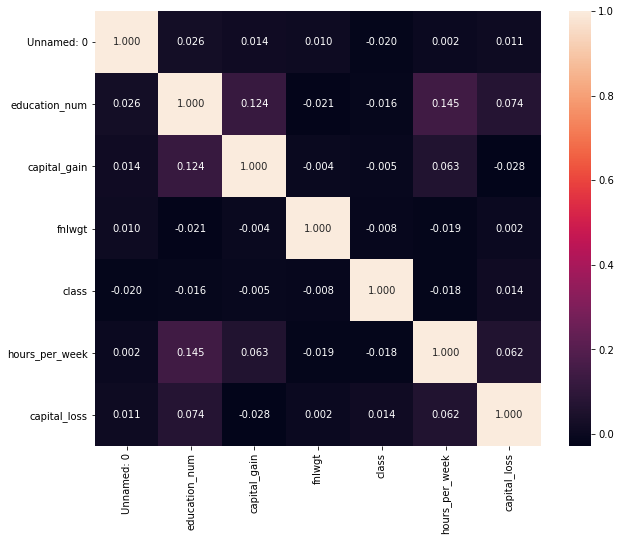

In [94]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_other_train_analysis.corr(), ax=ax, annot=True, fmt=".3f")

## Identifikácia problémov v dátach spolu s predpokladaným scenárom riešenia v ďalšej fáze

In [13]:
df_other_train[df_other_train.duplicated()]

,Unnamed: 0,name,address,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,education,fnlwgt,class,income,medical_info,native-country,hours-per-week,capital-loss,workclass


In [14]:
df_personal_train[df_personal_train.duplicated()]

,Unnamed: 0,name,address,age,sex,date_of_birth


In [15]:
df_other_train[df_other_train.name.isin(df_other_train.name[df_other_train.name.duplicated()])].sort_values(by=['name'])

,Unnamed: 0,name,address,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,education,fnlwgt,class,income,medical_info,native-country,hours-per-week,capital-loss,workclass
2078,2078,Alex Stubblefield,"PSC 1476, Box 5156\r\nAPO AE 20184",White,Married-civ-spouse,Protective-serv,FALSE,10.0,Husband,0.0,Some-college,194417.0,NaN,>50K,"{'mean_glucose':'39.3046875','std_glucose':'42...",United-States,40.0,0.0,Local-gov
2682,2682,Alex Stubblefield,"PSC 1476, Box 5156\r\nAPO AE 20184",NaN,Married-civ-spouse,NaN,FALSE,10.0,Husband,0.0,Some-college,NaN,1.0,>50K,"{'mean_glucose':'39.3046875','std_glucose':'42...",United-States,40.0,0.0,Local-gov
2416,2416,Ashley Lyons,"4166 Sara Points\r\nHernandezview, WY 62853",White,Married-civ-spouse,Handlers-cleaners,f,9.0,Husband,NaN,HS-grad,155972.0,NaN,>50K,NaN,United-States,40.0,0.0,Private
467,467,Ashley Lyons,"4166 Sara Points\r\nHernandezview, WY 62853",White,Married-civ-spouse,NaN,f,9.0,Husband,0.0,HS-grad,NaN,0.0,>50K,"{'mean_glucose':'111.1953125','std_glucose':'4...",United-States,NaN,0.0,Private
2553,2553,Billy Clark,"3859 Melissa Bridge Apt. 723\r\nShawnfurt, GA ...",White,Divorced,Exec-managerial,f,9.0,Not-in-family,NaN,HS-grad,195516.0,0.0,<=50K,"{'mean_glucose':'103.8046875','std_glucose':'4...",United-States,40.0,0.0,Local-gov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,2845,William Ortiz,"11967 Melissa Squares\r\nEast Robin, DE 65168",Black,Separated,Other-service,f,12.0,NaN,0.0,Assoc-acdm,285865.0,0.0,<=50K,"{'mean_glucose':'116.734375','std_glucose':'51...",United-States,32.0,0.0,NaN
2025,2025,William Smith,045 Johnson Mountain Suite 137\r\nCourtneyland...,Amer-Indian-Eskimo,NaN,Prof-specialty,f,10.0,Husband,NaN,NaN,140474.0,0.0,<=50K,NaN,United-States,NaN,0.0,Private
2009,2009,William Smith,045 Johnson Mountain Suite 137\r\nCourtneyland...,Amer-Indian-Eskimo,Married-civ-spouse,Prof-specialty,f,10.0,Husband,0.0,Some-college,NaN,0.0,<=50K,"{'mean_glucose':'107.828125','std_glucose':'46...",United-States,40.0,0.0,Private
3806,3806,William Sullivan,"09205 Miller Locks Apt. 585\r\nPowellland, IN ...",White,Married-civ-spouse,Exec-managerial,f,10.0,NaN,0.0,Some-college,80324.0,0.0,NaN,"{'mean_glucose':'109.5625','std_glucose':'44.9...",NaN,62.0,1977.0,Private
